This illustrates how to generate a test dataset for DIST-S1.

In [1]:
from pathlib import Path

import geopandas as gpd
import numpy as np
import rasterio
from affine import Affine
from dem_stitcher.rio_window import get_cropped_profile
from dist_s1_enumerator import enumerate_one_dist_s1_product, localize_rtc_s1_ts
from rasterio.plot import show
from rasterio.transform import xy
from tqdm import tqdm

/Users/cmarshak/miniforge3/envs/dist-s1-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MGRS_TILE_ID = "10SGD"
TRACK_NUMBER = 137
post_date = "2025-01-02"

In [3]:
df_product = enumerate_one_dist_s1_product(
    MGRS_TILE_ID, track_number=TRACK_NUMBER, post_date=post_date,
)
df_product.head()

/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_17653/3182855200.py:1: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  df_product = enumerate_one_dist_s1_product(
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_17653/3182855200.py:1: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  df_product = enumerate_one_dist_s1_product(


,opera_id,jpl_burst_id,acq_dt,acq_date_for_mgrs_pass,polarizations,track_number,pass_id,url_crosspol,url_copol,geometry,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token,input_category
0,OPERA_L2_RTC-S1_T137-292318-IW1_20240904T01590...,T137-292318-IW1,2024-09-04 01:59:00+00:00,2024-09-04,VV+VH,137,649,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.88173 33.8894, -119.86874 34.04...",10SGD,2,137,pre
1,OPERA_L2_RTC-S1_T137-292318-IW1_20240916T01590...,T137-292318-IW1,2024-09-16 01:59:01+00:00,2024-09-16,VV+VH,137,651,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.88408 33.88926, -119.87119 34.0...",10SGD,2,137,pre
2,OPERA_L2_RTC-S1_T137-292318-IW1_20240928T01590...,T137-292318-IW1,2024-09-28 01:59:01+00:00,2024-09-28,VV+VH,137,653,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.8823 33.8891, -119.86943 34.046...",10SGD,2,137,pre
3,OPERA_L2_RTC-S1_T137-292318-IW1_20241010T01590...,T137-292318-IW1,2024-10-10 01:59:02+00:00,2024-10-10,VV+VH,137,655,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.88496 33.88923, -119.87222 34.0...",10SGD,2,137,pre
4,OPERA_L2_RTC-S1_T137-292318-IW1_20241022T01590...,T137-292318-IW1,2024-10-22 01:59:02+00:00,2024-10-22,VV+VH,137,657,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-120.88297 33.88976, -119.87021 34.0...",10SGD,2,137,pre


The library is relies on disk `io` so every relative path has to be precise. We want the data paths:
   - to be in `test_data`
   - to be consistent with how `dist-s1-enumerator` works so we want to not touch `<MGRS_TILE_ID> / <TRACK_NUMBER>/...`

In [22]:
out_dir = Path('out')
out_dir.mkdir(exist_ok=True, parents=True)

# Download products

In [29]:
df_product_loc = localize_rtc_s1_ts(df_product, out_dir, max_workers=5)

# Localize Table

In [30]:
track_token = df_product_loc.track_token.iloc[0]
mgrs_tile_id = df_product_loc.mgrs_tile_id.iloc[0]
date_token = df_product_loc.acq_date_for_mgrs_pass.iloc[0]

df_product.to_parquet(
    out_dir
    / f"{mgrs_tile_id}__{track_token}__{date_token}_dist_s1_inputs.parquet"
)

# Rewrite Rasters with Smaller Area

In [31]:
sample_loc_path = df_product_loc["loc_path_crosspol"].iloc[0]
with rasterio.open(sample_loc_path) as ds:
    X = ds.read(1)
    p = ds.profile

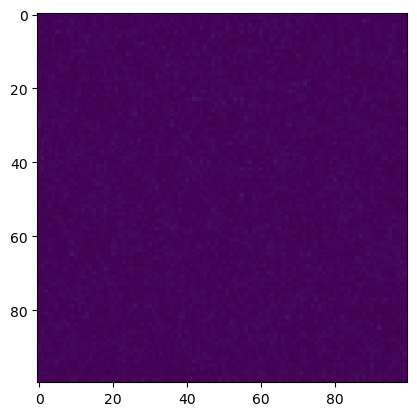

<Axes: >

In [32]:
SIZE = 100
sy = np.s_[600:600 + SIZE]
sx = np.s_[1100:1100 + SIZE]

show(X[sy, sx], vmin=0, vmax=0.15)

Again, we are making sure that we put was once in `out` into `test_data/cropped`.

In [72]:
cropped_data_dir = Path('test_data/cropped')
cropped_data_dir.mkdir(exist_ok=True, parents=True)

In [73]:
def crop_and_serialize_data(data_path: str) -> Path:
    src_path = Path(data_path)
    out_path = cropped_data_dir / src_path.relative_to(out_dir)
    out_parent = out_path.parent
    out_parent.mkdir(exist_ok=True, parents=True)
    with rasterio.open(src_path) as ds:
        X = ds.read(1)
        p = ds.profile
    p_c = get_cropped_profile(p, sx, sy)
    with rasterio.open(out_path, "w", **p_c) as ds:
        ds.write(X[sy, sx], 1)
    return str(out_path)

In [74]:
new_crosspol_paths = list(map(crop_and_serialize_data, df_product_loc.loc_path_crosspol[:]))
new_copol_paths = list(map(crop_and_serialize_data, df_product_loc.loc_path_copol[:]))

In [75]:
def update_path(data_path: str) -> str:
    src_path = Path(data_path)
    out_path = cropped_data_dir / src_path.relative_to(out_dir)
    if not out_path.exists():
        print(out_path)
    return str(out_path)

In [76]:
df_product_loc_small = df_product_loc.copy()
df_product_loc_small["loc_path_copol"] = df_product_loc.loc_path_copol.map(update_path)
df_product_loc_small["loc_path_crosspol"] = df_product_loc.loc_path_crosspol.map(update_path)


In [77]:
df_product_loc_small.to_parquet(
    cropped_data_dir / f"{mgrs_tile_id}__{track_token}__{date_token}_dist_s1_inputs.parquet"
)